In [1]:
import pandas as pd
import numpy as np
import mnist
import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

## Load the dataset

The MNIST database is available at http://yann.lecun.com/exdb/mnist/

The MNIST database is a dataset of handwritten digits. It has 60,000 training samples, and 10,000 test samples. Each image is represented by 28x28 pixels, each containing a value 0 - 255 with its grayscale value.

We will be using the `mnist` library to download images and labels from the MNIST database

The dataset is downloaded and cached in your temporary directory, so, calling the functions again, is much faster and doesn't hit the server.

In [2]:
import mnist

train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [3]:
print(f'train images shape: {train_images.shape}')
print(f'test images shape: {test_images.shape}')

train images shape: (60000, 28, 28)
test images shape: (10000, 28, 28)


## MNIST Images and labels

Let us see a sample of images in the training dataset.

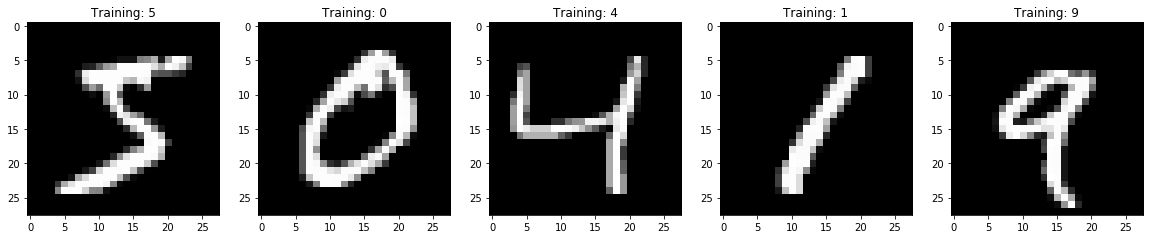

In [4]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(train_images[:5], train_labels[:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title(f'Training: {label}')

## Training and prediction using Logistic Regression

In [5]:
# Flatten images since the algorithm expects input in the form of a 1-D array
def flatten_images(images):
    n_samples, x_pixels, y_pixels = images.shape
    return images.reshape(n_samples, x_pixels*y_pixels)

# Displays the converged weights/co-efficients as an image. 
# Well converged values display a clear pattern of their respective digits.
def print_classification_vector(coef):
    # Pick max value from the co-efficient matrix
    scale = np.abs(coef).max()
    
    plt.figure(figsize=(20, 10))
    for i in range(coef.shape[0]):
        plt.subplot(2, 5, i+1)
        plt.imshow(coef[i].reshape(28,28), interpolation='nearest',
                       cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)

In [6]:
# Data pre-processing

train_data = flatten_images(train_images)
test_data = flatten_images(test_images)

# Scale data using minmax scaler, as it is more suited for images.
min_max_scaler = preprocessing.MinMaxScaler()
train_min_max = min_max_scaler.fit_transform(train_data)
test_min_max = min_max_scaler.transform(test_data)


### Baseline model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 244 seconds
Sparsity of the matrix: 8.545918367346939
Accuracy score: 0.9262
Classification vectors.. None
Wall time: 4min 4s


C:\Users\vandy\AppData\Local\Continuum\anaconda3\envs\mnist-playground\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min finished


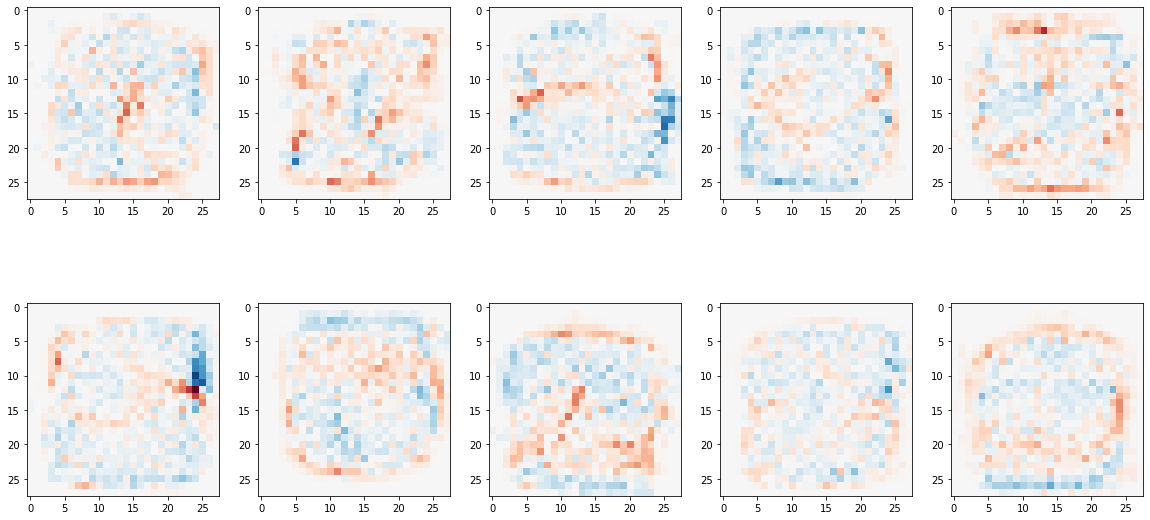

In [7]:
%%time

# Saga is chosen as the optimization algorithm as it is suitable for multiclass problems

clf = LogisticRegression(solver='saga', verbose=10)
clf.fit(train_min_max, train_labels)

predictions = clf.predict(test_min_max)

score = accuracy_score(test_labels, predictions)
sparsity = np.mean(clf.coef_ == 0) * 100

print(f'Sparsity of the matrix: {sparsity}')
print(f'Accuracy score: {score}')
print(f'Classification vectors.. {print_classification_vector(clf.coef_.copy())}')

It is a little surprising to see that a model that does not converge has an accuracy of 92.6%. The the classification vectors are not sparse, this tells us that the model might be generalizing a lot. Let us make sure the model converges and see how those classification vectors differ

### Improvements to Baseline: version 1

In this version, let us use tolerance for faster convergence and use L1 regularization to increase sparsity.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 4 epochs took 17 seconds
Sparsity of the matrix: 71.7984693877551
Accuracy score with l1 penalty: 0.8938
Classification vectors.. None
Wall time: 17.8 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s finished


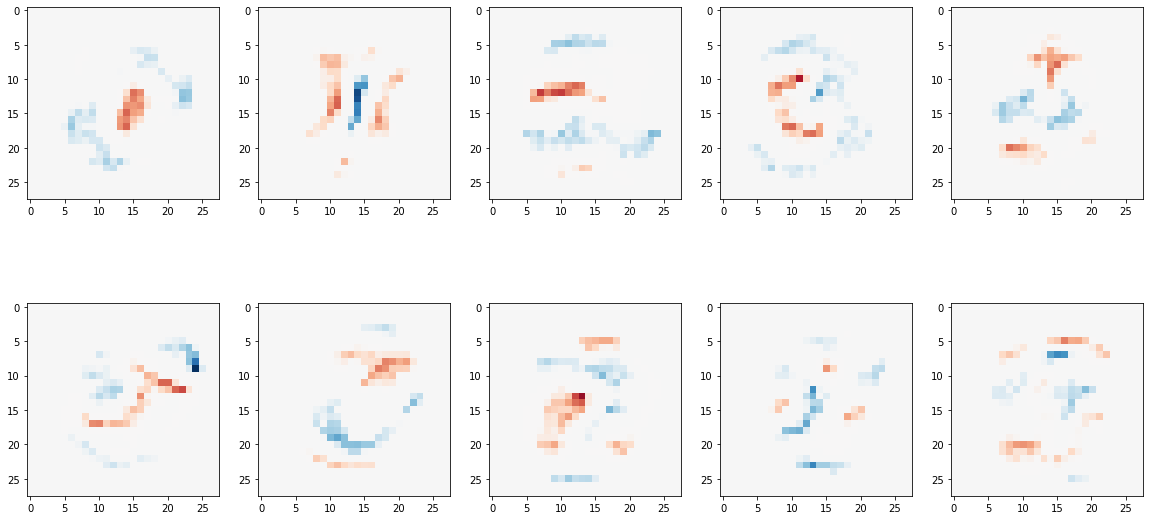

In [8]:
%%time

# Saga is chosen as the optimization algorithm as it is suitable for multiclass problems
# Turn up tolerance for faster convergence.
# Use l1 to increase the sparsity of the matrix, which helps in better classification

clf = LogisticRegression(C = 0.01, solver='saga', tol=0.1, penalty='l1', verbose=10)
clf.fit(train_min_max, train_labels)

predictions = clf.predict(test_min_max)

score = accuracy_score(test_labels, predictions)
sparsity = np.mean(clf.coef_ == 0) * 100

print(f'Sparsity of the matrix: {sparsity}')
print(f'Accuracy score with l1 penalty: {score}')
print(f'Classification vectors.. {print_classification_vector(clf.coef_.copy())}')

We can see a huge improvement in the performance. The total-time taken to run the model has dropped to 15s from 3min 19s. Adding tolerence seems to have made the difference. Tolerence helps in faster convergence by defining a stopping criteria. The training stops when the training loss becomes smaller than the threshold defined by the tolerence. Sparsity of the classification vectors has increased as well, which helps in better recognition of digits. Let us explore the confusion matrix to see if we can get some insights on the behaviour of our model.

## Confusion Matrix

In [9]:
# move to utils.py

def get_insights_from_confusion_matrix(confusion_matrix):
    n = 2
    print(f'{confusion_matrix} \n')
    
    for i, row in enumerate(confusion_matrix):
        row[i] = 0 # Assign 0 so that the current image is not considered as wrongly predicted (Stupid hack).
        top_misclassifications = row.argsort()[-3:][::-1]  # Get 3 highest values from array and reverse
        print(f'Majority of the images for {i} are wrongly predicted as {row.argmax()}')
        

get_insights_from_confusion_matrix(confusion_matrix(test_labels, predictions))

[[ 952    1    6    1    0    7    8    2    3    0]
 [   0 1099    5    4    0    2    4    2   19    0]
 [  10   15  890   14   18    0   18   23   33   11]
 [   6    1   22  894    1   34    6   14   21   11]
 [   2    6    3    3  881    3   15    3    9   57]
 [  18    4    4   47   17  725   29   13   25   10]
 [  12    5    6    1   17   20  884    4    9    0]
 [   5   18   27    3    8    1    0  931    4   31]
 [   7   24    9   20   12   30   24   11  813   24]
 [  10    9    5   13   56   14    1   21   11  869]] 

Majority of the images for 0 are wrongly predicted as 6
Majority of the images for 1 are wrongly predicted as 8
Majority of the images for 2 are wrongly predicted as 8
Majority of the images for 3 are wrongly predicted as 5
Majority of the images for 4 are wrongly predicted as 9
Majority of the images for 5 are wrongly predicted as 3
Majority of the images for 6 are wrongly predicted as 5
Majority of the images for 7 are wrongly predicted as 9
Majority of the ima

Numbers that have the same pattern seem to be misclassified. Majority of the numbers seem to be wrongly predicted as 5.

## Testing output for sanity check

Let us do a sanity check to see how the images look for both correctly classified and misclassified predictions and see if we can uncover more from the samples.

In [10]:
# Getting indexes for both misclassified and correctly classified images

def get_correct_and_misclassified_images(test_labels, predictions):
    index = 0
    misclassified_images = []
    correctly_classified_images = []

    for label, predict in zip(test_labels, predictions):
        if label == predict:
            correctly_classified_images.append(index)
        else:
            misclassified_images.append(index)
        index += 1
        
    return correctly_classified_images, misclassified_images

# Displays 10 misclassified images for each digit. 
def display_misclassified_images_for_each_digit(misclassified_indexes, predictions, test_labels, test_data):
    plt.figure(figsize=(20, 20))   
    for i in range(10):
        j = 0
        for misclassified_index in misclassified_indexes:
            if j == 10:
                break # break if limit of displaying 10 images is reached.
                
            title = ''           
            if j == 0: # to print a column header title.
                title = f'Predicted:{i},' 
            if predictions[misclassified_index] == i:
                plt.subplot(10, 10, i + 1 + (j*10))
                plt.imshow(test_data[misclassified_index].reshape(28,28), cmap=plt.cm.gray)
                plt.title(f'{title} Actual:{test_labels[misclassified_index]}', fontsize=10)
                plt.axis('off')
                j += 1

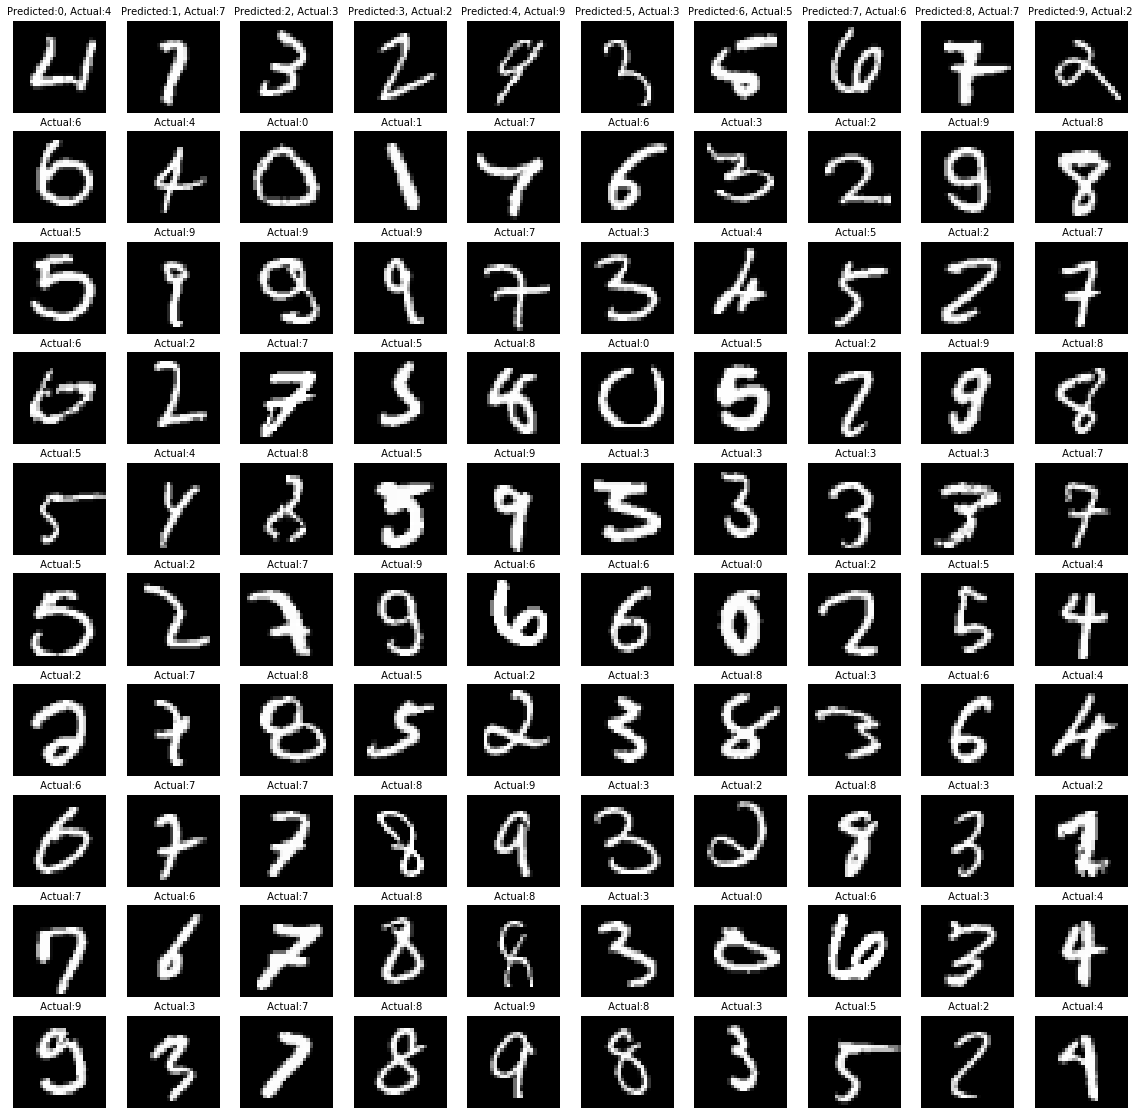

In [11]:
correctly_classified_images, misclassified_images = get_correct_and_misclassified_images(test_labels, predictions)           
display_misclassified_images_for_each_digit(misclassified_images, predictions, test_labels, test_data)

From the above misclassifications, below is a summary of observations and how we could improve the model:

1. Few numbers are consistently getting misclassified. Use cross-validation and hyperparameter tuning to improve training and inturn predict better.
2. Blurry, slanty digits and in few cases very fat digits seem to get misclassified. Probably train model with more blurry images or deslant and deskew images before training.

### Improvements to Baseline: version 2

#### Grid Search and Cross Validation

Let us come up with a custom grid search method that takes a range of values for regularization parameters, tolerence, max_iter, solvers and penalty. It will run a logistic regression model for each combination of those values and return results of the same.

In [12]:
import time
import itertools

# Runs a Logistic regression model for the entire range of parameters passed to the function. 
# Returns results of every combination of model.
def get_custom_grid_search_results(c_values, tol_values, max_iter, solvers, penalities):
    
    i = 0
    iter_results = []
    for c , tol, max_iter, solver, penalty in itertools.product(c_values, tol_values, max_iter, solvers, penalities):
        start = time.time()

        clf = LogisticRegression(C=c, solver=solver, tol=tol, penalty=penalty, max_iter=max_iter)
        clf.fit(train_min_max, train_labels)
        predictions = clf.predict(test_min_max)
        score = accuracy_score(test_labels, predictions)

        end = time.time()
        time_taken = end - start
        
        result = {
            'score': score,
            'c': c,
            'tolerence': tol,
            'max_iter': max_iter,
            'solver': solver,
            'penalty': penalty,
            'time_taken': time_taken,
            'coef': clf.coef_,
            'predictions': predictions,
            'sparsity': (np.mean(clf.coef_ == 0)) * 100
        }

        iter_results.append(result)
        print(f'Iteration {i} completed with parameters score: {result.score}, c: {result.c}, tolerence: {result.tolerence}  max_iter: {result.max_iter}, solver: {result.solver},  penalty: {result.penalty}, sparsity: {result.sparsity}')
        i += 1
        
    return iter_results
    

#### Grid search with L2 regularization

Running separate grid search for L1 and L2 regularization because all the solvers support L2 regularization for multiclass classification but only `saga` supports L1 regularization

In [ ]:
%%time

c_values = [0.0001, 0.001, 0.005, 0.01, 0.5, 0.1]
tol_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
max_iter = [100, 500, 1000]
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga'] # All 4 solvers support multi-class classification
penalities = ['l2'] # 'newton-cg', 'lbfgs', 'sag' do not support l1 penalty

iter_results = get_custom_grid_search_results(c_values, tol_values, max_iter, solvers, penalities)

As you can see from the above warning, few solvers failed to converge. But not being able to converge does not mean the model is bad. In our case, if the rate of accuracy loss does not go below a given `tolerence` value within n number of iterations, then we get this error. Let us see how the models have performed with respect to sparsity, time_taken and accuracy score.

In [35]:
pd.set_option('display.max_rows', 1000)

results = pd.DataFrame(iter_results)
report = results[['score', 'c', 'tolerence', 'max_iter', 'solver', 'penalty', 'time_taken', 'sparsity']]

In [62]:
# Sort by sparsity

report_by_sparsity = report.sort_values(by='sparsity', ascending=False)
report_by_sparsity.head()

,score,c,tolerence,max_iter,solver,penalty,time_taken,sparsity
430,0.8892,0.100,1.0,1000,sag,l2,1.485978,10.331633
279,0.9190,0.010,1.0,100,saga,l2,1.966617,10.331633
207,0.9162,0.005,1.0,100,saga,l2,1.974511,10.331633
278,0.9102,0.010,1.0,100,sag,l2,1.507062,10.204082
210,0.9130,0.005,1.0,500,sag,l2,1.503022,10.204082


In [63]:
# Sort by time taken

report_by_time_taken = report.sort_values(by='time_taken', ascending=False)
report_by_time_taken.head()

,score,c,tolerence,max_iter,solver,penalty,time_taken,sparsity
295,0.9261,0.5,0.00001,500,saga,l2,839.862240,8.545918
299,0.9261,0.5,0.00001,1000,saga,l2,836.926534,8.545918
311,0.9261,0.5,0.00010,1000,saga,l2,543.223688,8.545918
307,0.9261,0.5,0.00010,500,saga,l2,539.874621,8.545918
298,0.9261,0.5,0.00001,1000,sag,l2,336.712878,8.545918


In [64]:
# Sort by accuracy

report_by_accuracy_score = report.sort_values(by='score', ascending=False)
report_by_accuracy_score.head()

,score,c,tolerence,max_iter,solver,penalty,time_taken,sparsity
353,0.9264,0.5,1.00,500,lbfgs,l2,29.336500,8.545918
357,0.9264,0.5,1.00,1000,lbfgs,l2,29.272089,8.545918
326,0.9264,0.5,0.01,100,sag,l2,37.800337,8.545918
327,0.9264,0.5,0.01,100,saga,l2,60.330476,8.545918
335,0.9263,0.5,0.01,1000,saga,l2,62.013316,8.545918


From the above 3 tables, we can notice that the converged vectors are not very sparse. A very sparse matrix will lead to under-fitting and a highly dense matrix will result in over-fitting. We need to choose sparsity which strikes a balance between between the two. Looking at the classification vectors should give a good idea on choosing a model with ideal sparsity.

Coming to tolerence, the lower the tolerence, the higher is the time taken to run a model. Higher training times sometimes lead to overfitting. A tolerence between `1e-4` to `1e-1` seems like a decent range of values to be c

Regularization is used when there are a lot of independent variables, but very less data. The higher weights get more importance and there could be overfitting. Hence we use regularization to reduce the effects of large weights. For Logistic regression, unlike neural networks, we don't have to worry much about overfitting, hence we can relax the regularization parameter. For Logistic regression, C is defined as the inverse of learning rate: 

 C = $\frac 1{\lambda}$

Since C is the inverse of $\lambda$ the lower C value, the higher effect it has on the weights. Since we do not have to worry too much about regularization in Logistic regression as compared to neural networks, a C value in the range of 0.5 or 0.01 makes sense here.

Shortlisting a few models based on the above criteria and after doing a sanity check on the outputs:

`0.9256	0.5000	0.00100	100	lbfgs	l2	8.146949
0.9261	0.5000	0.01000	500	newton-cg	l2	30.381863
0.9187	0.0100	0.00100	100	saga	l2	34.835246
0.9264	0.5000	0.01000	100	sag	l2	37.800337	8.545918
`

Let us see how the models perform with L1 regularization.

#### Grid search with L1 regularization

Since only saga supports l1 penalty, let us do a grid search for saga with l1 penalty.

In [ ]:
%%time

l1_tol_values = [1e-4, 1e-3, 1e-2, 1e-1, 1] # Since saga takes a lot of time, eliminating 1e-5, to save running times.
solver = ['saga']
penalty = ['l1']

saga_results = get_custom_grid_search_results(c_values, l1_tol_values, max_iter, solver, penalty)

In [66]:
saga_with_l1_results = pd.DataFrame(saga_results)
saga_with_l1_report = saga_with_l1_results[['score', 'c', 'tolerence', 'max_iter', 'solver', 'penalty', 'time_taken', 'sparsity']]
saga_with_l1_report = saga_with_l1_report.sort_values(by='sparsity', ascending=False)
saga_with_l1_report.head()

,score,c,tolerence,max_iter,solver,penalty,time_taken,sparsity
0,0.1135,0.0001,0.0001,100,saga,l1,17.827888,100.0
2,0.1135,0.0001,0.0001,1000,saga,l1,11.179885,100.0
3,0.1135,0.0001,0.0010,100,saga,l1,8.409127,100.0
4,0.1135,0.0001,0.0010,500,saga,l1,16.645479,100.0
5,0.1135,0.0001,0.0010,1000,saga,l1,16.525391,100.0


L1 regularization seems to take a lot of time as compared to L2. Also the sparsity of classification vectors using L1 is more as compared to L2.
Shortlisting the below 2 models from L1 regularization for cross-validation.

`
0.9231	0.1000	0.0010	100	saga	l1	385.104021	78.073980
0.9229	0.1000	0.0100	100	saga	l1	106.761495	74.387755`

#### Cross-validation


For cross validation, scikit learn has a wide variety of techniques, some of which are:

1) Standard K-fold - every fold is different. The split is chosen in consecutive order without shuffling. If the training-size is small, there are chances that the same split will be considered with different validation sets resulting in similar training scores. <br />
2) Stratified K-fold - a variant of K-fold, that preserves percentage of samples. <br />
3) StratifiedShuffleSplit - A random permutation cross-validator performing stratified splits. This does not guarantee that all folds are different. But it preserves the percentage of samples and also overcomes the disadvantage of K-fold by shuffling the splits. 

For our usecase, since the training and test sets come shuffled, we don't have to worry much about shuffling. Also our input data is not imbalanced. So we don't have to worry about having a stratified split. Let us go ahead with the default K-fold (5 folds in our case) cross-validation <br />

In [53]:
# params from l1 regularization
# 0.9256	0.5000	0.00100	100	lbfgs	l2	8.146949
# 0.9261	0.5000	0.01000	500	newton-cg	l2	30.381863
# 0.9187	0.0100	0.00100	100	saga	l2	34.835246
# 0.9264	0.5000	0.01000	100	sag	l2	37.800337	8.545918

# params from L2 regularization
# 0.9231	0.1000	0.0010	100	saga	l1	385.104021	78.073980
# 0.9229	0.1000	0.0100	100	saga	l1	106.761495	74.387755

# acc:0.9278, C:0.5000, tol:0.00010, max_iter:1000, solver:saga, penalty:l1 - Resulted in overfitting.


param_list = [{'c': 0.5000, 'tol': 0.00100 , 'max_iter': 100 , 'solver':'lbfgs', 'penalty':'l2', 'acc': 92.56}, 
              {'c': 0.5000, 'tol': 0.01000 , 'max_iter': 500 , 'solver':'newton-cg', 'penalty':'l2', 'acc': 92.61},
              {'c': 0.0100, 'tol': 0.00100 , 'max_iter': 100 , 'solver':'saga', 'penalty':'l2', 'acc': 91.87},
              {'c': 0.5000, 'tol': 0.01000 , 'max_iter': 100 , 'solver':'sag', 'penalty':'l2', 'acc': 92.64},
              {'c': 0.1000, 'tol': 0.0010 , 'max_iter': 100 , 'solver':'saga', 'penalty':'l1', 'acc': 92.31},
              {'c': 0.1000, 'tol': 0.0100 , 'max_iter': 100 , 'solver':'saga', 'penalty':'l1', 'acc': 92.29}]

In [46]:
%%time

from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

train_sizes_list = []
train_scores_list = []
validation_scores_list = []
fit_times_list = []
score_times_list = []

for params in param_list:
    estimator = LogisticRegression(C = params['c'], solver=params['solver'], tol=params['tol'], penalty=params['penalty'], max_iter=params['max_iter'], verbose=10)

    cv = KFold(n_splits=5)
    train_sizes, train_scores, validation_scores, fit_times, score_times = learning_curve(estimator, 
                                                                                    train_min_max, 
                                                                                    train_labels, 
                                                                                    cv=cv, 
                                                                                    n_jobs=4, 
                                                                                    scoring='accuracy',
                                                                                    return_times=True)
    
    train_sizes_list.append(train_sizes)
    train_scores_list.append(train_scores)
    validation_scores_list.append(validation_scores)
    fit_times_list.append(fit_times)
    score_times_list.append(score_times)

Wall time: 38min 39s


#### Learning curves

There are 2 types of learning curves:
        
1. Optimization Learning Curves: Learning curves calculated on the metric by which the parameters of the model are being optimized, e.g. loss.
2. Performance Learning Curves: Learning curves calculated on the metric by which the model will be evaluated and selected, e.g. accuracy.

We will focus on the performance learning curves in order to decide on a best performing model. 

In [57]:
# plot train vs validation scores
def plot_learning_curve(train_sizes, train_scores_mean, train_scores_std, 
                        validation_scores_mean, validation_scores_std):
    plt.grid()
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1, color="r")

    plt.plot(train_sizes, validation_scores_mean, 'o-', color='g', label='Validation Score')
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                      validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

    plt.ylabel('Score')
    plt.legend(loc="best")
    

# Plot n_samples vs fit_times
def plot_scalability_curve(train_sizes, fit_times_mean, fit_times_std):  
    plt.grid()
    plt.plot(train_sizes, fit_times_mean, 'o-')
    plt.fill_between(train_sizes, fit_times_mean - fit_times_std,
                     fit_times_mean + fit_times_std, alpha=0.1,)
    plt.xlabel("Training examples")
    plt.ylabel("fit times")
    plt.title("Scalability of the model")

    
# Plots fit_times vs train scores   
def plot_performance_curve(fit_times_mean, validation_scores_mean, validation_scores_std):
    plt.grid()
    plt.plot(fit_times_mean, validation_scores_mean)
    plt.fill_between(fit_times_mean, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1)
    plt.xlabel('fit times')
    plt.ylabel('Training examples')
    plt.title("Performance of the model")

In [48]:
# Return mean and std for given parameters
def get_mean_and_std(train_scores, validation_scores, fit_times):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # To-do: Wrap the result into an object
    return train_scores_mean, train_scores_std, validation_scores_mean, validation_scores_std, fit_times_mean, fit_times_std

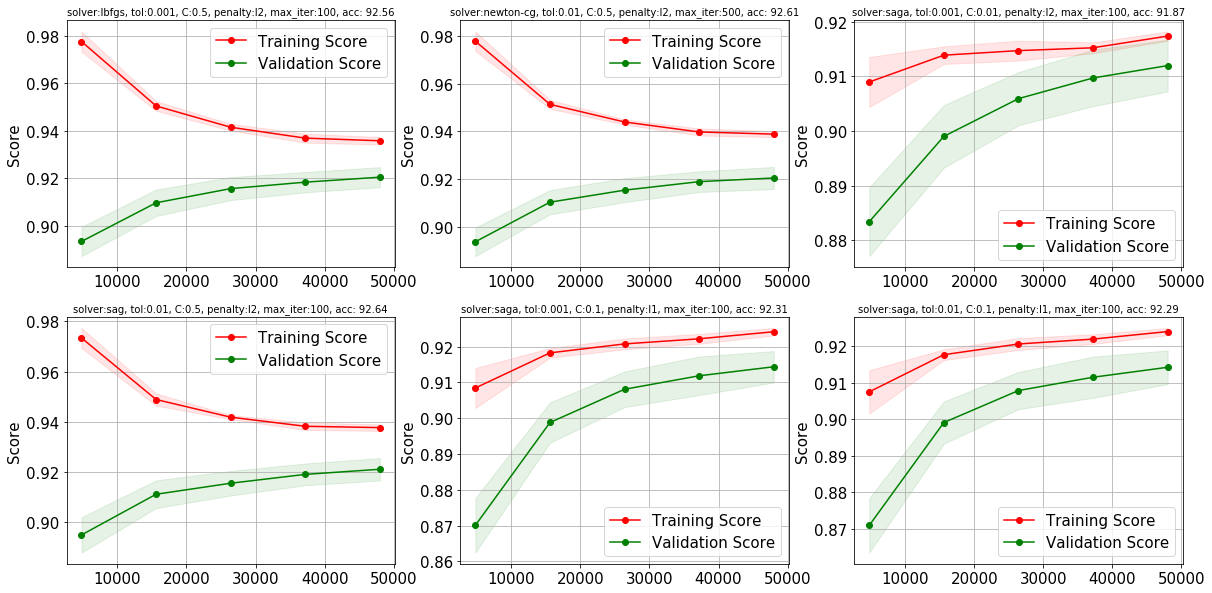

In [54]:
# Plot validation curves for each cross-validation set

plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15})

for i, params in enumerate(param_list):
    train_sizes = train_sizes_list[i]

    train_scores_mean, train_scores_std, validation_scores_mean, \
    validation_scores_std, fit_times_mean, fit_times_std = get_mean_and_std(train_scores_list[i],
                                                                             validation_scores_list[i],
                                                                             fit_times_list[i])
    # score_times_mean = np.mean(score_times_list[i], axis=1)
    
    plt.subplot(2, 3, i + 1)
    title = f"solver:{params['solver']}, tol:{(params['tol'])}, C:{params['c']}, penalty:{params['penalty']}, max_iter:{params['max_iter']}, acc: {params['acc']}"

    plt.title(title, fontsize=10)
    plot_learning_curve(train_sizes, train_scores_mean, train_scores_std, validation_scores_mean, validation_scores_std)

#### Best fit model

Looking at the above learning curves, the curves with accuracy 92.56, 92.61 and 92.64 seem to be underfitting and the rest 3 seem to do well when more data is added. Also notice reducing C value (increasing regularization) helps in better training of the model. Choosing the highest accuracy among the remaining 3 models, the one with acc 92.31 seems to be the best fit model.

#### Learning, scalability and performance curves for the best fit model

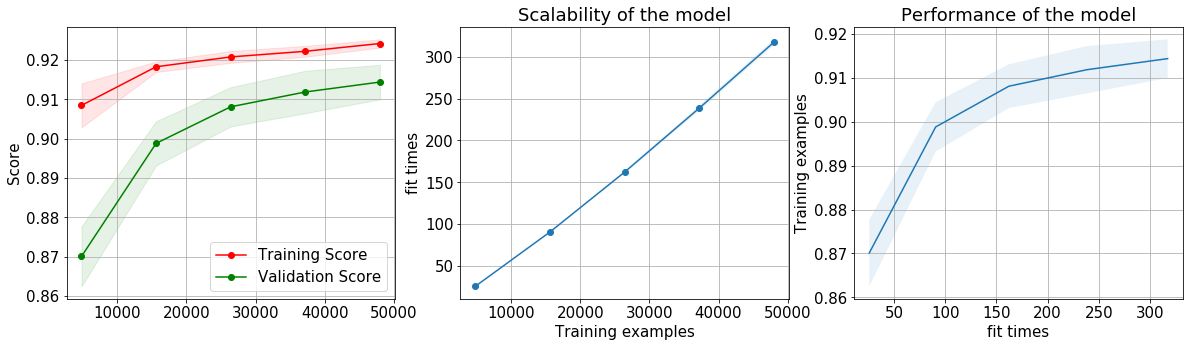

In [61]:
plt.figure(figsize=(20, 5))

# Index of the best performing model
index = 4
params = param_list[index]
train_scores_mean, train_scores_std, validation_scores_mean, \
    validation_scores_std, fit_times_mean, fit_times_std = get_mean_and_std(train_scores_list[index],
                                                                             validation_scores_list[index],
                                                                             fit_times_list[index])
plt.subplot(1, 3, 1)
plot_learning_curve(train_sizes, train_scores_mean, train_scores_std, validation_scores_mean, validation_scores_std)

plt.subplot(1, 3, 2)
plot_scalability_curve(train_sizes, fit_times_mean, fit_times_std)

plt.subplot(1, 3, 3)
plot_performance_curve(fit_times_mean, validation_scores_mean, validation_scores_std)

Best fit model: `{'c': 0.1000, 'tol': 0.0010 , 'max_iter': 100 , 'solver':'saga', 'penalty':'l1', 'acc': 92.31}`

References:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html
https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
Confusion matrix: https://www.python-course.eu/confusion_matrix.php
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
Preprocessing
https://fsix.github.io/mnist/
Synthetic data generation:
https://towardsdatascience.com/synthetic-data-generation-a-must-have-skill-for-new-data-scientists-915896c0c1ae
https://towardsdatascience.com/do-you-need-synthetic-data-for-your-ai-project-e7ecc2072d6b
https://towardsdatascience.com/how-uber-uses-synthetic-data-to-speed-up-training-cc989c23ded4
Learning Curves:
https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
https://medium.com/ml-research-lab/chapter-3-bias-and-variance-trade-off-in-machine-learning-a449fa1e2729
https://www.dataquest.io/blog/learning-curves-machine-learning/
Regularization: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c